# Immune Cells Training data

In [3]:
import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut, GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from pathlib import Path

def split_dataset(data, metadata):
    test_sample_names = (
        data.columns.to_series()
        .sample(frac=0.2)
        .tolist()
    )
    train_sample_names = [s for s in data.columns if s not in test_sample_names]

    print(f"Total samples: {data.shape[1]}")
    print(f"Train samples: {len(train_sample_names)}")
    print(f"Test samples:  {len(test_sample_names)}")

    train_data = data[train_sample_names]       # 行 = 基因，列 = 样本
    test_data = data[test_sample_names].T       # 行 = 样本，列 = 基因

    train_metadata = metadata.loc[train_sample_names]
    test_metadata = metadata.loc[test_sample_names]
    return train_data, test_data, train_metadata, test_metadata

## Initialization: assigning the directories

In [4]:
# directory listed
dataset_dir = "./Dataset/ImmuneCellsSignature"
cell_type = "CMonocyte"
data = pd.read_csv(f"{dataset_dir}/{cell_type}_Top100VIP_VST_Counts.csv", index_col=0, header=0)
metadata = pd.read_csv(f"{dataset_dir}/{cell_type}_metadata.csv", index_col=0, header=0)

In [5]:
def model(dataset_anova, metadata, test_data, param_grid=None):
    """
    1) no SMOTE，
    2) using GridSearchCV to find best_params, best_cv_acc；
    3) train the model based on the training set and best_params；
    4) predict the test data。
   return : best_params, best_cv_acc, predictions_series
    """
    # 1. prepare training data
    X = dataset_anova.T
    y = LabelEncoder().fit_transform(metadata['Group'])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    pipeline = Pipeline([
        # ('smote', SMOTE(random_state=42)),
        ('svc', SVC(probability=True, max_iter=1000))
    ])

    # 3. default search range if NOT GIVEN
    if param_grid is None:
        param_grid = [
            {"kernel": ["linear"], "C": [0.1, 1, 10], "gamma": ["scale", "auto"]},
            {"kernel": ["poly"],   "degree": [2, 3, 4, 5], "gamma": ["scale", "auto"]}
        ]

    # 4. GridSearchCV
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring="accuracy",
        return_train_score=True,
        n_jobs=-1,
        verbose=2
    )
    gs.fit(X, y)


    results_df = pd.DataFrame(gs.cv_results_)
    summary = results_df[['params', 'mean_test_score', 'std_test_score']] \
                .sort_values('mean_test_score', ascending=False)
    print(summary.to_string())
    
    out_csv = Path("./result/ImmuneCells/gridsearch_summary.csv")
    out_csv.parent.mkdir(parents=True, exist_ok=True) 
    summary.to_csv("./result/ImmuneCells/gridsearch_summary.csv", index=False)

    best_params = gs.best_params_
    best_cv_acc = gs.best_score_
    print(f"Best params: {best_params}, CV Accuracy: {best_cv_acc:.4f}")

    final_model = gs.best_estimator_
    final_model.fit(X, y)

    # 6. Pr5ediction on the testing set
    predictions = final_model.predict(test_data)
    predictions_series = pd.Series(predictions, index=test_data.index, name="Prediction")

    return best_params, best_cv_acc, predictions_series

In [6]:
# Notice here: HYPER_SEARCH indicate whether the next cell will execute:
# 1. GridCV search of 5 fold cross-validation based on the grid given; if True
# 2. Run with given hyper parameter; if False
HYPER_SEARCH = False

The script is able to perform hyper parameter search or testing the performance at each run. Our parameter  used for each types of immune cells are listed below

- Monocyte: 
  - linear
  - C = 0.1
  - gamma = scale

- Bnaive:

  - linear

  - C = 1
  - gamma = scale

- CD4EM

  - poly 3
  - C = 1
  - gamma = scale

- CD8Naive  

  - poly 3
  - C =1 
  - scale

- CMonocyte

  - poly 4
  - C = 1
  - scale

- NK

  - linear
  - c = 1
  - scale

- Treg

  - linear
  - c = 0.1
  - scale

In [8]:
if HYPER_SEARCH:
    print("Parameter searching start:")
    train_data, test_data, train_metadata, test_metadata = split_dataset(data, metadata)
    # ===================== 5-fold CV 的 param_grid =====================
    param_grid = [
        {
            "svc__kernel": ["linear"],
            "svc__C": [0.1, 1, 10],
            "svc__gamma": ["scale", "auto"],
        },
        {
            "svc__kernel": ["poly"],
            "svc__degree": [2, 3, 4, 5],
            "svc__C": [0.1, 1, 10],
            "svc__gamma": ["scale", "auto"],
        },
    ]

    # 5 fold cross validation
    best_params, best_cv_acc, test_predictions = model(
        dataset_anova=train_data,
        metadata=train_metadata,
        test_data=test_data,
        param_grid=param_grid,
    )

    print(f"Best hyper-parameters of {cell_type} from 5-fold CV:")
    print(best_params)
    print(f"Best CV accuracy: {best_cv_acc:.4f}")

else:
    results = []
    POS_LABEL = "T1D"
    for i in range(1000):
        train_data, test_data, train_metadata, test_metadata = split_dataset(data, metadata)
 
        le = LabelEncoder()
        y_train = le.fit_transform(train_metadata["Group"])
        y_test = le.transform(test_metadata["Group"])
        pos_idx = le.transform([POS_LABEL])[0]
        neg_idx = 1 - pos_idx  
        svc = SVC(
            kernel="linear",
            C=1,
            gamma="scale",
            probability=True,
            max_iter=1000,
        )

        svc.fit(train_data.T, y_train)
        y_pred = svc.predict(test_data)

        tn, fp, fn, tp = confusion_matrix(
            y_test, y_pred, labels=[neg_idx, pos_idx]
        ).ravel()

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        accuracy    = (tp + tn) / (tp + tn + fp + fn)

        results.append({
            "Accuracy": accuracy,
            "Specificity": specificity,
            "Sensitivity": sensitivity,
        })
        # 计算 1000 次的平均值
    results_df = pd.DataFrame(results)
    mean_sens = results_df["Sensitivity"].mean()
    mean_spec = results_df["Specificity"].mean()
    mean_acc  = results_df["Accuracy"].mean()

    results_df.to_csv(f"./result" + f"/ImmuneCells/{cell_type}.csv")
    print(f"Mean Sensitivity (TPR) over 1000 runs: {mean_sens:.4f}")
    print(f"Mean Specificity (TNR) over 1000 runs: {mean_spec:.4f}")
    print(f"Mean Accuracy over 1000 runs:          {mean_acc:.4f}")


Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samples: 59
Test samples:  15
Total samples: 74
Train samp

## Visualization of different types of immune cells result

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [ ]:
# 1. types of immune cells and their dataset
file_map = {
    "Scaffold":   "Scaffold.csv",
    "B Naive":    "BNaive.csv",
    "CD4 EM":     "CD4EM.csv",
    "CD8 Naive":  "CD8Naive.csv",
    "C Monocyte": "CMonocyte.csv",
    "NK":         "NK.csv",
    "Treg":       "Treg.csv",
}
base_dir = Path("./result/ImmuneCells/")
needed_cols = ["Accuracy", "Specificity", "Sensitivity"]
metrics = ["Accuracy", "Specificity", "Sensitivity"]


In [ ]:
# 2. read csv and assemble into long dataframe for later plot
dfs = []
for group_name, fname in file_map.items():
    fpath = base_dir / fname
    df = pd.read_csv(fpath)

    missing = [c for c in needed_cols if c not in df.columns]
    if missing:
        raise ValueError(f"{fname} 中缺少列: {missing}")

    df_long = (
        df[needed_cols]
        .melt(var_name="Metric", value_name="Value")
        .dropna(subset=["Value"])
        .assign(Group=group_name)
    )
    dfs.append(df_long)

plot_df = pd.concat(dfs, ignore_index=True)

# set order
plot_df["Group"] = pd.Categorical(plot_df["Group"], categories=list(file_map.keys()), ordered=True)
plot_df["Metric"] = pd.Categorical(plot_df["Metric"], categories=metrics, ordered=True)

In [ ]:
# Color adjustment
PALETTE = [
    # 7 color hex codes
    "#4E79A7", "#A0CBE8", "#F28E2B", "#FFBE7D", "#59A14F", "#8CD17D", "#B07AA1"
]

if len(PALETTE) != len(file_map):
    raise ValueError("PALETTE 长度必须等于组数（7）。请用 R 导出的 floral 颜色替换。")

group_to_color = dict(zip(file_map.keys(), PALETTE))


In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(10, 5))

# metric assigned with spacing
metric_x = {m: i * 2 for i, m in enumerate(metrics)}

n_groups = len(file_map)
dodge_width = 0.9         
box_total_width = 0.8      
step = dodge_width / n_groups
offsets = (np.arange(n_groups) - (n_groups - 1) / 2.0) * step

all_data = []
all_pos = []
all_colors = []

for mi, m in enumerate(metrics):
    base = metric_x[m]
    for gi, g in enumerate(file_map.keys()):
        vals = plot_df.loc[(plot_df["Metric"] == m) & (plot_df["Group"] == g), "Value"].to_numpy()
        if vals.size == 0:
            continue
        all_data.append(vals)
        all_pos.append(base + offsets[gi])
        all_colors.append(group_to_color[g])

bp = ax.boxplot(
    all_data,
    positions=all_pos,
    widths=box_total_width / n_groups * 0.95,
    patch_artist=True,
    showfliers=True,
    flierprops=dict(markersize=0.7),
    boxprops=dict(linewidth=0.6),
    whiskerprops=dict(linewidth=0.6),
    capprops=dict(linewidth=0.6),
    medianprops=dict(linewidth=0.6),
)

for patch, c in zip(bp["boxes"], all_colors):
    patch.set_facecolor(c)

ax.set_xlim(-1, 5)  
ax.set_xticks([metric_x[m] for m in metrics])
ax.set_xticklabels(metrics)

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.01, 0.1))

ax.set_xlabel("Metric", fontweight="bold")
ax.set_ylabel("Score", fontweight="bold")
ax.set_title("SVC Performance by Metric and Cell Type", fontweight="bold", pad=10)

ax.grid(False)  
for spine in ax.spines.values():
    spine.set_visible(True)

# legend（rightside）
handles = [Patch(facecolor=group_to_color[g], edgecolor="black", label=g) for g in file_map.keys()]
leg = ax.legend(handles=handles, title="Cell type", loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
leg.get_title().set_fontweight("bold")

plt.tight_layout()

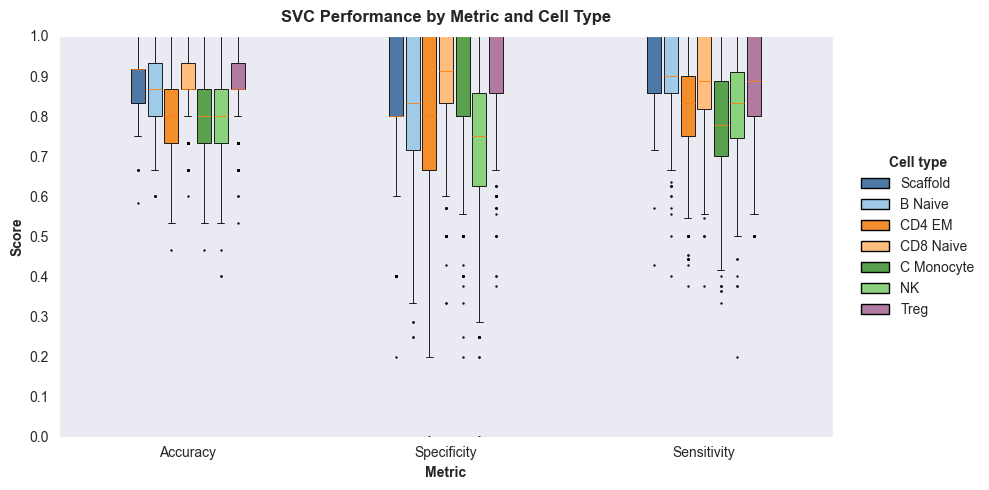

In [10]:
out_png = Path("./result/ImmuneCells/svc_performance_boxplot_combined_ggplot.png")
out_pdf = Path("./result/ImmuneCells/svc_performance_boxplot_combined_ggplot.pdf")
out_png.parent.mkdir(parents=True, exist_ok=True)

plt.savefig(out_png, dpi=300)
plt.savefig(out_pdf)
plt.show()
